In [2]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import (cross_val_predict, train_test_split, GridSearchCV,
                                     StratifiedKFold, KFold)
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (classification_report, accuracy_score, roc_auc_score, log_loss)
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import KFold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


# Load and preprocess data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_file_path = '/content/drive/My Drive/Colab Notebooks/Churn_bank_exited/train.csv'
test_file_path = '/content/drive/My Drive/Colab Notebooks/Churn_bank_exited/test.csv'

df_train = pd.read_csv(train_file_path)

In [6]:
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


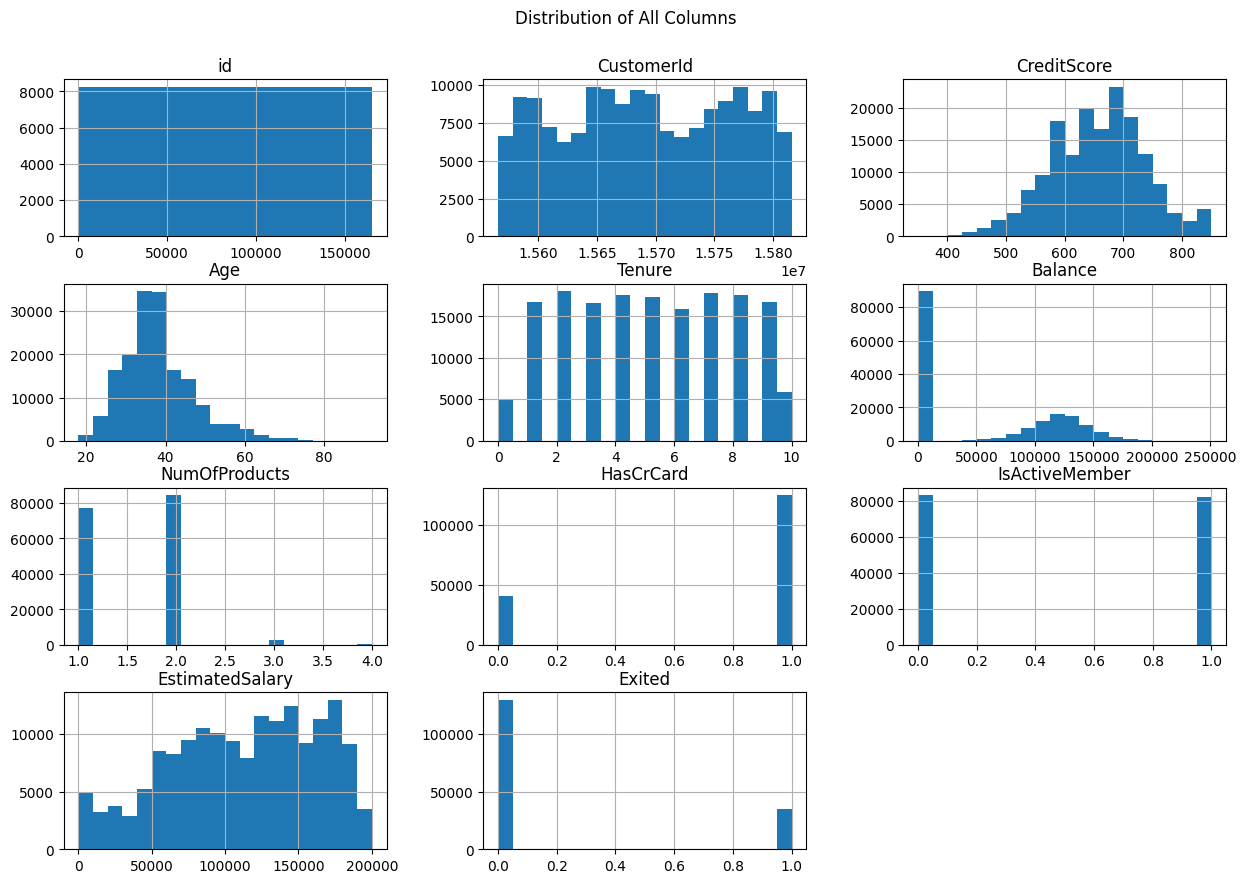

In [7]:
# lets see the distribution of teh features
df_train.hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribution of All Columns", y=0.95)
plt.show()


## detecting outliers

In [8]:
def detect_outliers_zscore(df, columns, threshold=3):
    """
    Detect and count outliers in specified columns of a DataFrame using Z-score.
    """
    outliers_count = {}

    for column in columns:
        # Calculate Z-scores for each data point in the column
        z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())

        # Identify outliers based on the threshold
        outliers_mask = z_scores > threshold

        # Count the number of outliers
        num_outliers = outliers_mask.sum()
        outliers_count[column] = num_outliers

    return outliers_count

# Specify the columns for which you want to detect outliers
columns_to_detect_outliers =  ['CreditScore', 'Balance', 'EstimatedSalary']

# Call the function to detect and count outliers in the specified columns
outliers_count = detect_outliers_zscore(df_train, columns_to_detect_outliers)

# Print the count of outliers for each column
for column, count in outliers_count.items():
    print(f"Number of outliers in {column}: {count}")

Number of outliers in CreditScore: 146
Number of outliers in Balance: 3
Number of outliers in EstimatedSalary: 0


In [9]:
# defining the column to be preceed
columns_to_replace_outliers = ['CreditScore']

# Function to replace outliers with median
def replace_outliers_with_median(df, columns):
    df_cleaned = df.copy()

    for column in columns:
        # Calculate Z-scores for each data point in the column
        z_scores = (df_cleaned[column] - df_cleaned[column].median()) / (df_cleaned[column] - df_cleaned[column].median()).abs().mean()

        # Identify outliers
        outliers_mask = z_scores > 3

        # Replace outliers with the median
        df_cleaned.loc[outliers_mask, column] = df_cleaned[column].median()

    return df_cleaned

# Call the function to replace outliers with the median
df_median_replaced = replace_outliers_with_median(df_train, columns_to_replace_outliers)


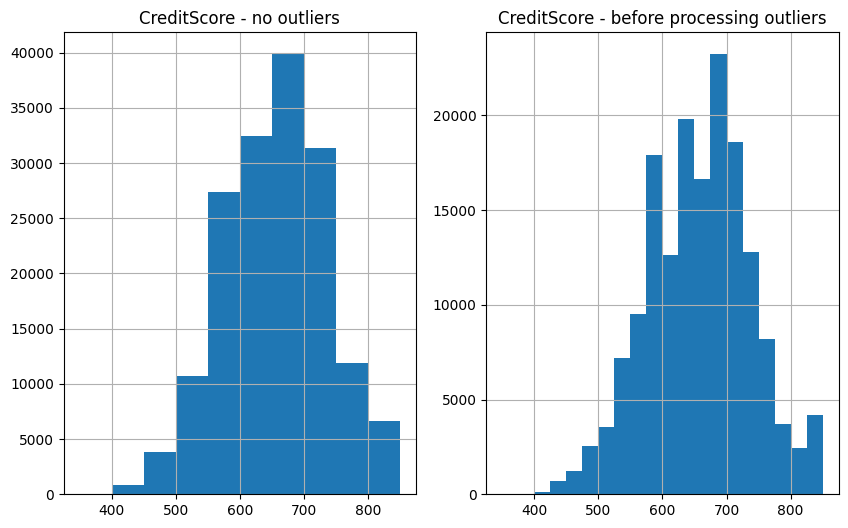

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

df_median_replaced['CreditScore'].hist(ax=axs[0])
axs[0].set_title("CreditScore - no outliers")

df_train['CreditScore'].hist(bins=20, figsize=(10, 6), ax=axs[1])
axs[1].set_title("CreditScore - before processing outliers")

plt.show()

## define preprocess steps:

- drop duplicates
- set categ for genders, countries
- create new features as Bal_Tenure, Bal_Age, Estimsal_Age, Age_Bins
- drop unnecessary columns as 'id', 'CustomerId', 'Surname'
- scaling data, becouse the range of the data is very different

In [11]:
def preprocess_data(df):
    df = df.drop_duplicates()
    df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1}).astype('int8')
    df['Geography'] = df['Geography'].map({'France': 0, 'Germany': 1, 'Spain': 2}).astype('int8')
    df['Bal_Tenure'] = df['Balance'] * df['Tenure']
    df['Bal_Age'] = df['Balance'] * df['Age']
    df['Estimsal_Age'] = df['EstimatedSalary'] * df['Age']
    df["Age_Bins"] = pd.qcut(df["Age"], 16, np.arange(0, 16, 1, dtype=int))
    # df['Ten_NumOfProd'] = df['NumOfProducts']*df['Tenure']
    df.drop(['id', 'CustomerId', 'Surname'], inplace=True, axis=1)
    # df.fillna(-1, inplace=True)
    scaler = RobustScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)  # Convert back to DataFrame
    return df_scaled

In [12]:
df_train_pp = preprocess_data(df_median_replaced)
df_train_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  float64
 1   Geography        165034 non-null  float64
 2   Gender           165034 non-null  float64
 3   Age              165034 non-null  float64
 4   Tenure           165034 non-null  float64
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  float64
 7   HasCrCard        165034 non-null  float64
 8   IsActiveMember   165034 non-null  float64
 9   EstimatedSalary  165034 non-null  float64
 10  Exited           165034 non-null  float64
 11  Bal_Tenure       165034 non-null  float64
 12  Bal_Age          165034 non-null  float64
 13  Estimsal_Age     165034 non-null  float64
 14  Age_Bins         165034 non-null  float64
dtypes: float64(15)
memory usage: 18.9 MB


Trying to look out if data distribution is balanced one

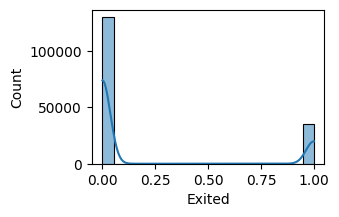

In [33]:
fig, ax = plt.subplots(figsize=(3, 2))
sns.histplot(df_train_pp['Exited'], kde=True)
plt.show()

## balancing data, oversample method

The data is not balanced. Class '1' (exited clients) is much smaller than '0' (not exited clients). This will affect efficiency of the model and forecasts.

In [14]:
from imblearn.over_sampling import RandomOverSampler

y = df_train_pp['Exited']
X = df_train_pp.drop('Exited', axis=1)

ros = RandomOverSampler(sampling_strategy=1)
X_res_over, y_res_over = ros.fit_resample(X, y)
X_res_over.shape, y_res_over.shape, y.shape, X.shape

((260226, 14), (260226,), (165034,), (165034, 14))

now the classes are wqually distributed

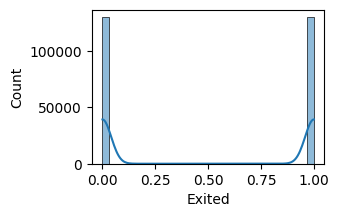

In [15]:
fig, ax = plt.subplots(figsize=(3, 2))
sns.histplot(y_res_over, kde=True)
plt.show()

# Train step

In [16]:
# useoversampled data
y = y_res_over
X = X_res_over

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((208180, 14), (52046, 14), (208180,), (52046,))

##  Histogram Gradient Boosting Classifier

In [17]:
# initiate  HistGradientBoostingClassifier model

Hist_GB = HistGradientBoostingClassifier(max_iter=700, learning_rate=0.1, min_samples_leaf=20, max_depth=6, random_state=42)

# Create KFold for cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and compute ROC AUC scores
Hist_GB_cross_val = cross_val_score(Hist_GB, X_train, y_train, cv=kf, scoring='roc_auc', n_jobs=-1)

# Print the average cross-validated ROC AUC score
print(f"CV roc_auc score of Hist GB (mean value) is {round(Hist_GB_cross_val.mean(), 4)}")

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

CV roc_auc score of Hist GB (mean value) is 0.9117
2024-04-12 07:59:49


CV score of Hist GB is 0.9117 (mean value)

## Train Hist_GB model

In [18]:
Hist_GB.fit(X_train, y_train)

HistGradientBoostingClassifier(max_depth=6, max_iter=700, random_state=42)

## Evaluate the model

In [19]:
# lables on the test set
y_pred = Hist_GB.predict(X_test)

# Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83     26008
         1.0       0.83      0.83      0.83     26038

    accuracy                           0.83     52046
   macro avg       0.83      0.83      0.83     52046
weighted avg       0.83      0.83      0.83     52046

Confusion Matrix:
[[21678  4330]
 [ 4341 21697]]


    True Negatives (TN): 21,678 were correctly predicted as class 0
    False Positives (FP): 4,330 were incorrectly predicted as class 1 when they were actually class 0
    False Negatives (FN): 4,341 were incorrectly predicted as class 0 when they were actually class 1
    True Positives (TP): 21,697 were correctly predicted as class 1

    The model shows a good balance between precision and recall for both classes

    Depending on the specific business task and the costs of false positives vs. false negatives, we might want to adjust
    the decision threshold or explore model tuning to optimize for one metric over another.

# Testing step

In [20]:
# load test data
df_test = pd.read_csv(test_file_path)

In [21]:
# transform test data the same way as we transform train data
df_test_pp = preprocess_data(df_test)

In [22]:
X_test = df_test_pp
y_pred_proba_test = Hist_GB.predict_proba(X_test)[:, 1]

In [23]:
# predict probabilities for the test set
X_test = df_test_pp
y_pred_proba_test = Hist_GB.predict_proba(X_test)[:, 1]

# submission

In [34]:
# load sample data
sample_file_path = '/content/drive/My Drive/Colab Notebooks/Churn_bank_exited/sample_submission.csv'
sample = pd.read_csv(sample_file_path)

# Вивести перші рядки та розмір
print(sample.head())
print(sample.shape)

       id  Exited
0  165034     0.5
1  165035     0.5
2  165036     0.5
3  165037     0.5
4  165038     0.5
(110023, 2)


In [35]:
# Assuming y_pred_proba_test is a pandas Series or NumPy array with your predictions
sample['Exited'] = y_pred_proba_test

# Зберегти DataFrame у CSV файл
sample.to_csv('/content/drive/MyDrive/sample_subm_churn_bank_HistGB.csv', index=False)

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

sample['Exited']

2024-04-12 09:30:00


0         0.090544
1         0.940633
2         0.065238
3         0.510215
4         0.642493
            ...   
110018    0.199590
110019    0.414230
110020    0.094493
110021    0.407585
110022    0.429853
Name: Exited, Length: 110023, dtype: float64

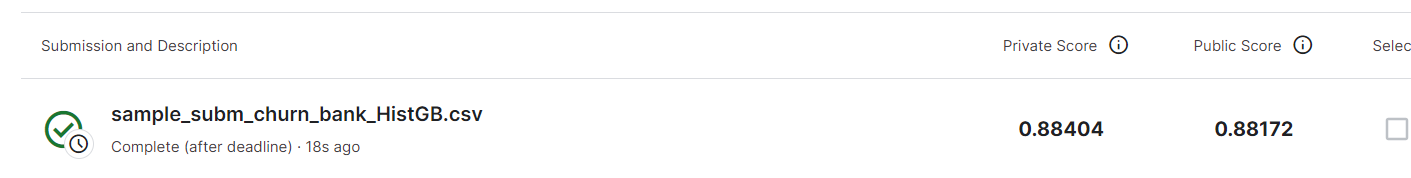

**Data set taken from Kaggle**

https://www.kaggle.com/competitions/playground-series-s4e1/overview

my best result **AUC 0.88604**


1 place on board with **AUC 0.905**